In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pump-sensor-data/sensor.csv


In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
import os
import lightgbm as lgb
from tqdm import tqdm_notebook
from catboost import CatBoostClassifier
from xgboost import XGBRegressor
from sklearn import linear_model
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
import time
smote=SMOTE()

pd.set_option('display.max_columns',None)
# pd.set_option('display.max_rows',None)

In [3]:
df = pd.read_csv("/kaggle/input/pump-sensor-data/sensor.csv")
df.head()

,Unnamed: 0,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,sensor_22,sensor_23,sensor_24,sensor_25,sensor_26,sensor_27,sensor_28,sensor_29,sensor_30,sensor_31,sensor_32,sensor_33,sensor_34,sensor_35,sensor_36,sensor_37,sensor_38,sensor_39,sensor_40,sensor_41,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,0,2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,37.22740,47.52422,31.11716,1.681353,419.5747,NaN,461.8781,466.3284,2.565284,665.3993,398.9862,880.0001,498.8926,975.9409,627.6740,741.7151,848.0708,429.0377,785.1935,684.9443,594.4445,682.8125,680.4416,433.7037,171.9375,341.9039,195.0655,90.32386,40.36458,31.51042,70.57291,30.98958,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
1,1,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,37.22740,47.52422,31.11716,1.681353,419.5747,NaN,461.8781,466.3284,2.565284,665.3993,398.9862,880.0001,498.8926,975.9409,627.6740,741.7151,848.0708,429.0377,785.1935,684.9443,594.4445,682.8125,680.4416,433.7037,171.9375,341.9039,195.0655,90.32386,40.36458,31.51042,70.57291,30.98958,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2,2,2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,15.61777,15.01013,37.86777,48.17723,32.08894,1.708474,420.8480,NaN,462.7798,459.6364,2.500062,666.2234,399.9418,880.4237,501.3617,982.7342,631.1326,740.8031,849.8997,454.2390,778.5734,715.6266,661.5740,721.8750,694.7721,441.2635,169.9820,343.1955,200.9694,93.90508,41.40625,31.25000,69.53125,30.46875,31.770830,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL
3,3,2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,15.69734,15.08247,38.57977,48.65607,31.67221,1.579427,420.7494,NaN,462.8980,460.8858,2.509521,666.0114,399.1046,878.8917,499.0430,977.7520,625.4076,739.2722,847.7579,474.8731,779.5091,690.4011,686.1111,754.6875,683.3831,446.2493,166.4987,343.9586,193.1689,101.04060,41.92708,31.51042,72.13541,30.46875,31.510420,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL
4,4,2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,15.69734,15.08247,39.48939,49.06298,31.95202,1.683831,419.8926,NaN,461.4906,468.2206,2.604785,663.2111,400.5426,882.5874,498.5383,979.5755,627.1830,737.6033,846.9182,408.8159,785.2307,704.6937,631.4814,766.1458,702.4431,433.9081,164.7498,339.9630,193.8770,101.70380,42.70833,31.51042,76.82291,30.98958,31.510420,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL


In [4]:
df['machine_status'].value_counts()

NORMAL        205836
RECOVERING     14477
BROKEN             7
Name: machine_status, dtype: int64

In [5]:
loc=[17153,17154,17155,17156,17157,17158]
loc1=[24508,24509,24510,24511,24512]
loc2=[69316,69317,69318,69319,69320,69321]
loc3=[77788,77789,77790,77791,77792,77793,77794,77795]
loc4=[128038,128039,128040,128041,128042]
loc5=[141129,141130,141131,141132,141133]
loc6=[166438,166439,166440,166441,166442]

In [6]:
df.iloc[loc6]

,Unnamed: 0,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,sensor_22,sensor_23,sensor_24,sensor_25,sensor_26,sensor_27,sensor_28,sensor_29,sensor_30,sensor_31,sensor_32,sensor_33,sensor_34,sensor_35,sensor_36,sensor_37,sensor_38,sensor_39,sensor_40,sensor_41,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
166438,166438,2018-07-25 13:58:00,2.322743,45.833330,52.99479,43.92361,3.336227,70.48889,14.46036,16.16030,15.73351,15.01013,38.87765,49.75908,31.78839,12.18041,419.6096,NaN,462.2329,466.0083,2.577086,667.1351,398.3854,881.7244,536.0204,1095.544,630.5479,743.5366,981.5860,488.0563,1009.694,559.3523,678.2407,947.9166,1016.9990,558.1667,344.4498,490.6038,796.3863,39.34733,51.82291,40.36458,100.52080,36.197914,36.458330,49.73958,52.08333,52.08333,61.34259,44.84954,249.1319,72.33796,NaN,206.8866,NORMAL
166439,166439,2018-07-25 13:59:00,2.315856,45.789930,53.03819,43.88021,3.336227,68.74365,14.43866,16.07350,15.53096,15.05353,38.21849,49.73039,32.32672,12.20967,420.0334,NaN,460.0883,460.4448,2.509833,664.8566,399.6012,880.7674,535.4742,1092.324,628.6292,743.1452,982.4372,511.7988,1025.110,559.1011,743.5185,960.4166,998.0515,551.9908,339.3840,492.3628,796.2476,53.73619,51.04166,40.62500,104.68750,36.197910,36.458332,50.52083,52.66204,53.24074,63.36805,44.84954,244.5023,72.62731,NaN,209.7801,NORMAL
166440,166440,2018-07-25 14:00:00,2.318808,45.833332,52.99479,43.88021,420.503448,72.52040,14.18547,16.24711,15.69734,15.05353,36.71748,50.04619,30.74288,12.21786,420.8600,NaN,463.5181,455.2702,2.468381,665.9402,399.0930,880.8410,531.8727,1093.579,626.4651,740.6738,981.4561,490.7728,1023.166,551.2756,703.7037,971.8749,1013.3760,546.6656,363.0320,522.5594,812.8298,44.77601,50.00000,39.06250,102.86460,35.416660,36.458330,51.30208,52.10200,52.66204,67.12963,43.98148,230.3241,69.73380,NaN,205.7292,BROKEN
166441,166441,2018-07-25 14:01:00,2.318808,45.833332,52.99479,43.88021,420.503448,72.52040,14.18547,16.24711,15.69734,15.05353,36.71748,50.04619,30.74288,12.21786,420.8600,NaN,463.5181,455.2702,2.468381,665.9402,399.0930,880.8410,531.8727,1093.579,626.4651,740.6738,981.4561,490.7728,1023.166,551.2756,703.7037,971.8749,1013.3760,546.6656,363.0320,522.5594,812.8298,44.77601,50.00000,39.06250,102.86460,35.416660,36.458330,51.30208,52.10200,52.66204,67.12963,43.98148,230.3241,69.73380,NaN,205.7292,RECOVERING
166442,166442,2018-07-25 14:02:00,2.252893,45.833332,53.03819,43.88021,55.515045,72.44621,14.43866,16.16753,15.69734,15.08247,37.41580,50.72017,30.82077,12.22845,422.4220,NaN,463.4329,470.3403,2.638817,666.3651,400.9771,878.7145,532.5884,1097.179,629.9147,741.3097,982.1048,505.5175,1008.496,564.6308,706.9445,984.8958,1007.4070,548.6494,356.6773,519.1464,809.1069,48.52049,51.30208,37.76041,98.69791,34.895830,36.458330,50.52083,52.08333,52.37268,68.28703,43.69213,226.2731,68.28703,NaN,202.8356,RECOVERING


In [7]:
df[df['machine_status']=='BROKEN']

,Unnamed: 0,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,sensor_22,sensor_23,sensor_24,sensor_25,sensor_26,sensor_27,sensor_28,sensor_29,sensor_30,sensor_31,sensor_32,sensor_33,sensor_34,sensor_35,sensor_36,sensor_37,sensor_38,sensor_39,sensor_40,sensor_41,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
17155,17155,2018-04-12 21:55:00,0.000000,53.342010,52.821180,43.402775,202.526031,49.79289,3.219039,16.890910,16.869210,15.082470,35.530850,3.625588,1.602259,0.237091,407.4979,NaN,451.3286,449.1867,2.387357,652.2382,390.5987,858.3630,461.2751,955.74270,614.6786,653.9383,753.0676,570.81680,1161.1310,783.6125,710.6481,960.9374,742.2943,566.6204,261.7709,399.129100,301.1411,114.20790,52.08333,35.41666,87.23958,39.583330,36.979160,50.78125,50.92593,51.215280,50.636570,46.006940,409.143500,121.527800,401.909700,324.6528,BROKEN
24510,24510,2018-04-18 00:30:00,1.093982,42.534720,47.699650,41.449650,206.038757,60.30106,12.304690,15.154800,14.185470,13.867190,28.304880,30.434710,21.437910,6.803444,420.0946,NaN,460.7847,457.7386,2.481055,664.2351,398.1912,879.1428,458.3324,944.30770,625.1230,650.4600,748.0622,502.59550,1063.0030,784.2626,671.2963,1016.6670,828.1685,578.9925,177.4708,411.165200,434.2556,73.31284,37.76041,32.81250,71.61458,28.645830,29.947916,42.70833,34.72222,31.539350,34.432870,33.275460,59.895830,44.560180,177.662000,183.7384,BROKEN
69318,69318,2018-05-19 03:18:00,2.258796,47.265630,52.734370,43.446178,200.115738,66.14643,13.592300,15.914350,15.147570,14.793110,43.998860,43.623220,22.736040,9.277993,420.3359,NaN,463.0843,462.6495,2.539193,665.5446,399.1660,880.9252,498.6224,997.63640,619.0558,719.8438,867.5176,551.63670,1154.4050,761.1199,655.5555,1024.4790,849.8132,608.9143,171.3203,350.311700,285.3491,75.20248,47.39583,29.16667,66.66666,32.291660,31.250000,39.06250,35.01157,37.905090,39.062500,45.428240,144.675900,49.768520,246.238400,257.5231,BROKEN
77790,77790,2018-05-25 00:30:00,2.321759,47.482640,51.475693,42.795135,612.152800,67.30158,14.062500,16.608800,15.943290,15.596060,27.092980,44.793620,32.745590,2.178048,420.7917,NaN,463.3876,464.5768,2.557975,665.4158,399.1982,885.1603,533.6134,982.50690,627.0386,746.0360,854.0722,478.34040,1095.9630,724.8124,698.6111,971.8749,882.1304,499.8158,171.7490,354.075700,250.9113,72.70645,381.77080,417.18750,427.34370,212.760400,176.822900,202.34370,65.68287,57.870370,127.893500,153.935200,155.381900,65.682870,220.196800,267.3611,BROKEN
128040,128040,2018-06-28 22:00:00,0.364005,40.190970,45.225690,40.190971,201.368622,0.00000,11.335360,15.270540,15.183740,15.118630,2.002474,1.960537,0.000000,0.000000,197.9393,NaN,206.4634,193.7957,0.444666,108.9490,125.4787,158.0601,128.2272,96.38937,103.7937,143.1029,156.3189,21.31752,258.0632,109.4662,297.2222,575.0000,436.2560,258.6194,343.9342,694.479126,367.8615,23.78439,28.38542,22.13542,36.71875,23.177082,24.739580,32.29166,28.06713,28.067129,29.513889,29.224537,29.224537,29.513889,32.407406,NaN,BROKEN
141131,141131,2018-07-08 00:11:00,0.001968,45.138890,52.907990,45.355900,500.000000,1.40131,0.028935,0.036169,0.036169,0.007234,25.977650,23.970270,19.995600,11.076400,421.6618,NaN,464.8507,470.9483,2.632338,669.1102,399.5446,880.8264,536.3282,1091.49300,628.2361,759.8998,946.8455,509.98580,1042.8290,562.6080,668.9814,1037.5000,947.3692,517.4770,287.9145,575.356500,616.8983,30.04753,48.69791,31.51042,39.32291,35.416660,32.812500,36.19791,37.32639,35.300930,38.194440,43.402780,99.537030,44.849540,192.129600,174.7685,BROKEN
166440,166440,2018-07-25 14:00:00,2.318808,45.833332,52.994790,43.880210,420.503448,72.52040,14.185470,16.247110,15.697340,15.053530,36.717480,50.046190,30.742880,12.217860,420.8600,NaN,463.5181,455.2702,2.468381,665.9402,399.0930,880.8410,531.8727,1093.57900,626.4651,740.6

In [8]:
col_na=['sensor_50','sensor_51']

In [9]:
df[df['machine_status']=='RECOVERING']

,Unnamed: 0,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,sensor_22,sensor_23,sensor_24,sensor_25,sensor_26,sensor_27,sensor_28,sensor_29,sensor_30,sensor_31,sensor_32,sensor_33,sensor_34,sensor_35,sensor_36,sensor_37,sensor_38,sensor_39,sensor_40,sensor_41,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
17156,17156,2018-04-12 21:56:00,0.000000,53.55902,52.777770,43.402775,204.725098,53.74214,3.045428,17.42621,15.740740,16.17477,40.310710,3.730241,1.612210,0.318798,404.9974,NaN,450.2004,454.0266,2.448104,651.1287,390.6628,857.0173,461.6187,951.3060,612.6481,652.3843,750.5814,550.9968,1118.1630,773.6210,704.6296,1003.1250,714.9668,548.0704,270.0769,403.3277,299.2007,110.52630,53.64583,35.41666,84.63541,40.62500,36.979164,49.479160,50.34722,51.21528,49.18982,49.47917,431.7130,133.1019,419.2708,341.7245,RECOVERING
17157,17157,2018-04-12 21:57:00,0.000000,53.55902,52.777770,43.402775,201.137131,52.49996,7.537616,13.53443,9.324364,16.05179,38.930980,3.816472,1.631223,0.342867,409.9810,NaN,447.9742,449.0287,2.410462,650.5953,390.4939,863.1273,458.5190,948.8156,615.3629,646.3538,749.3739,553.7806,1147.2190,783.5280,716.2037,1040.1040,740.6817,561.4838,265.9168,415.0607,305.2495,115.34480,55.20833,35.15625,81.25000,40.88541,36.979160,48.177080,49.76852,50.92593,48.03241,53.81944,451.3889,140.0463,433.1597,466.1458,RECOVERING
17158,17158,2018-04-12 21:58:00,0.000000,52.77777,52.690970,43.402770,204.030655,57.19875,7.609953,16.60880,16.203700,16.09520,33.433750,3.860711,1.622106,0.304665,412.2902,NaN,449.5466,453.7787,2.429593,652.1424,390.2556,857.9081,461.1630,950.7607,614.9879,649.2152,746.4882,541.1052,1131.8090,787.4129,678.2407,976.5624,719.6953,558.5663,266.8813,415.8537,306.2030,105.04380,57.03125,35.15625,79.16666,41.40625,36.718750,46.875000,48.03241,50.34722,47.45370,58.15972,466.4352,144.9653,442.7083,366.0301,RECOVERING
17159,17159,2018-04-12 21:59:00,0.000000,52.60416,52.734370,43.446180,203.567688,50.96181,7.573785,16.70284,16.160300,16.08796,33.132260,4.496508,1.650150,0.606178,408.3951,NaN,450.6098,444.7706,2.361692,652.0457,390.4180,858.0203,460.7399,949.6810,614.2903,649.3373,748.6567,546.8779,1148.8040,782.2913,682.4074,930.2083,723.4662,550.8478,263.7073,403.5153,303.2734,113.03400,57.55208,35.41666,75.26041,42.18750,36.718750,45.833330,47.45370,49.76852,46.58565,63.65741,474.8264,149.0162,449.6528,374.4213,RECOVERING
17160,17160,2018-04-12 22:00:00,NaN,52.51736,52.690970,43.446180,203.567688,49.78948,7.559317,16.56539,16.239870,16.05179,35.345990,12.028980,1.904167,0.589342,411.0616,NaN,449.2088,441.3550,2.311379,650.0242,391.6447,864.0715,459.4494,950.6841,614.7383,649.4260,750.3677,550.1708,1145.0630,780.6435,707.8704,949.9999,720.6281,542.5764,270.2823,410.3059,297.6039,119.86980,55.98958,35.41666,64.84375,44.53125,36.718750,44.270830,46.29630,48.03241,45.13889,75.23148,477.7199,162.6157,448.7847,356.1921,RECOVERING
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166511,166511,2018-07-25 15:11:00,0.310880,46.48438,51.171870,46.527775,152.526031,60.77931,15.089700,17.62876,18.200230,16.39902,4.347953,0.493511,1.723150,0.000000,420.3740,NaN,458.9563,473.0108,2.655957,665.0773,398.9306,876.3478,534.0463,1088.5370,627.2612,741.9148,981.1793,514.0930,126.5598,598.6487,706.0185,955.7291,1008.2310,553.1983,364.1920,534.5963,838.0055,68.15515,79.94791,78.64583,64.32291,65.36458,54.687500,59.895830,77.83565,73.78472,58.44907,58.15972,295.4283,260.4167,NaN,211.2269,RECOVERING
166512,166512,2018-07-25 15:12:00,0.304977,46.39757,51.085070,46.527770,152.178802,61.24545,15.089700,17.62153,18.243630,16.31944

In [10]:
df['Unnamed: 0'].nunique()

220320

In [11]:
a=(df.isnull().sum())/len(df)*100
a[a>1]

sensor_00      4.633261
sensor_06      2.177741
sensor_07      2.474129
sensor_08      2.317992
sensor_09      2.085603
sensor_15    100.000000
sensor_50     34.956881
sensor_51      6.982117
dtype: float64

In [12]:
col=['sensor_15','Unnamed: 0','timestamp']

In [13]:
df=df.drop(columns=col)

In [14]:
a=(df.isnull().sum())/len(df)*100
a[a>1]

sensor_00     4.633261
sensor_06     2.177741
sensor_07     2.474129
sensor_08     2.317992
sensor_09     2.085603
sensor_50    34.956881
sensor_51     6.982117
dtype: float64

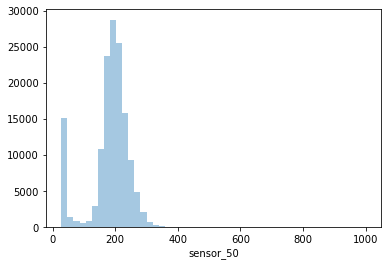

In [15]:
sns.distplot(df['sensor_50'],kde=False)

In [16]:
df['sensor_50'].describe()

count    143303.000000
mean        183.049260
std          65.258650
min          27.488426
25%         167.534700
50%         193.865700
75%         219.907400
max        1000.000000
Name: sensor_50, dtype: float64

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220320 entries, 0 to 220319
Data columns (total 52 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   sensor_00       210112 non-null  float64
 1   sensor_01       219951 non-null  float64
 2   sensor_02       220301 non-null  float64
 3   sensor_03       220301 non-null  float64
 4   sensor_04       220301 non-null  float64
 5   sensor_05       220301 non-null  float64
 6   sensor_06       215522 non-null  float64
 7   sensor_07       214869 non-null  float64
 8   sensor_08       215213 non-null  float64
 9   sensor_09       215725 non-null  float64
 10  sensor_10       220301 non-null  float64
 11  sensor_11       220301 non-null  float64
 12  sensor_12       220301 non-null  float64
 13  sensor_13       220301 non-null  float64
 14  sensor_14       220299 non-null  float64
 15  sensor_16       220289 non-null  float64
 16  sensor_17       220274 non-null  float64
 17  sensor_18 

In [18]:
df.describe()

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,sensor_22,sensor_23,sensor_24,sensor_25,sensor_26,sensor_27,sensor_28,sensor_29,sensor_30,sensor_31,sensor_32,sensor_33,sensor_34,sensor_35,sensor_36,sensor_37,sensor_38,sensor_39,sensor_40,sensor_41,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51
count,210112.000000,219951.000000,220301.000000,220301.000000,220301.000000,220301.000000,215522.000000,214869.000000,215213.000000,215725.000000,220301.000000,220301.000000,220301.000000,220301.000000,220299.000000,220289.000000,220274.000000,220274.000000,220304.000000,220304.000000,220304.000000,220279.000000,220304.000000,220304.000000,220284.000000,220300.000000,220304.000000,220304.000000,220248.000000,220059.000000,220304.00000,220252.000000,220304.000000,220304.000000,220304.000000,220304.000000,220304.000000,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,220293.000000,143303.000000,204937.000000
mean,2.372221,47.591611,50.867392,43.752481,590.673936,73.396414,13.501537,15.843152,15.200721,14.799210,41.470339,41.918319,29.136975,7.078858,376.860041,416.472892,421.127517,2.303785,590.829775,360.805165,796.225942,459.792815,922.609264,556.235397,649.144799,786.411781,501.506589,851.690339,576.195305,614.596442,863.32310,804.283915,486.405980,234.971776,427.129817,593.033876,60.787360,49.655946,36.610444,68.844530,35.365126,35.453455,43.879591,42.656877,43.094984,48.018585,44.340903,150.889044,57.119968,183.049260,202.699667
std,0.412227,3.296666,3.666820,2.418887,144.023912,17.298247,2.163736,2.201155,2.037390,2.091963,12.093519,13.056425,10.113935,6.901755,113.206382,126.072642,129.156175,0.765883,199.345820,101.974118,226.679317,154.528337,291.835280,182.297979,220.865166,246.663608,169.823173,313.074032,225.764091,195.726872,283.54476,260.602361,150.751836,88.376065,141.772519,289.385511,37.604883,10.540397,15.613723,21.371139,7.898665,10.259521,11.044404,11.576355,12.837520,15.641284,10.442437,82.244957,19.143598,65.258650,109.588607
min,0.000000,0.000000,33.159720,31.640620,2.798032,0.000000,0.014468,0.000000,0.028935,0.000000,0.000000,0.000000,0.000000,0.000000,32.409550,0.000000,0.000000,0.000000,0.000000,0.000000,95.527660,0.000000,0.000000,0.000000,0.000000,43.154790,0.000000,4.319347,0.636574,0.000000,23.95833,0.240716,6.460602,54.882370,0.000000,2.260970,0.000000,24.479166,19.270830,23.437500,20.833330,22.135416,24.479166,25.752316,26.331018,26.331018,27.199070,26.331018,26.620370,27.488426,27.777779
25%,2.438831,46.310760,50.390620,42.838539,626.620400,69.976260,13.346350,15.907120,15.183740,15.053530,40.705260,38.856420,28.686810,1.538516,418.103250,459.453400,454.138825,2.447542,662.768975,398.021500,875.464400,478.962600,950.922400,601.151050,693.957800,790.489575,448.297950,782.682625,518.947225,627.777800,839.06240,760.607475,489.761075,172.486300,353.176625,288.547575,28.799220,45.572910,32.552080,57.812500,32.552080,32.812500,39.583330,36.747684,36.747684,40.509258,39.062500,83.912030,47.743060,167.534700,179.108800
50%,2.456539,48.133678,51.649300,44.227428,632.638916,75.576790,13.642940,16.167530,15.494790,15.082470,44.291340,45.363140,32.515830,2.929809,420.106200,462.856100,462.020250,2.533704,665.672400,399.367000,879.697600,531.855900,981.925000,625.873500,740.203500,861.869600,494.468450,967.279850,564.872500,668.981400,917.70830,878.850750,512.271750,226.356050,473.349350,709.668050,64.295485,49.479160,35.416660,66.406250,34.895832,35.156250,42.968750,40.509260,40.219910,44.849540,42.534720,138.020800,52.662040,193.865700,197.338000
75%,2.499826,49.479160,52.777770,45.312500,637.615723,80.912150,14.539930,16.427950,15.697340,15.118630,47.463760,49.656540,34.939730,12.859520,420.997100,464

In [19]:
df['sensor_50'].value_counts()

31.828703     760
32.407406     667
28.067129     622
190.972200    609
193.865700    601
             ... 
368.923600      1
57.870369       1
483.506900      1
385.127300      1
155.092590      1
Name: sensor_50, Length: 1135, dtype: int64

In [20]:
df['sensor_51'].iloc[128020]

nan

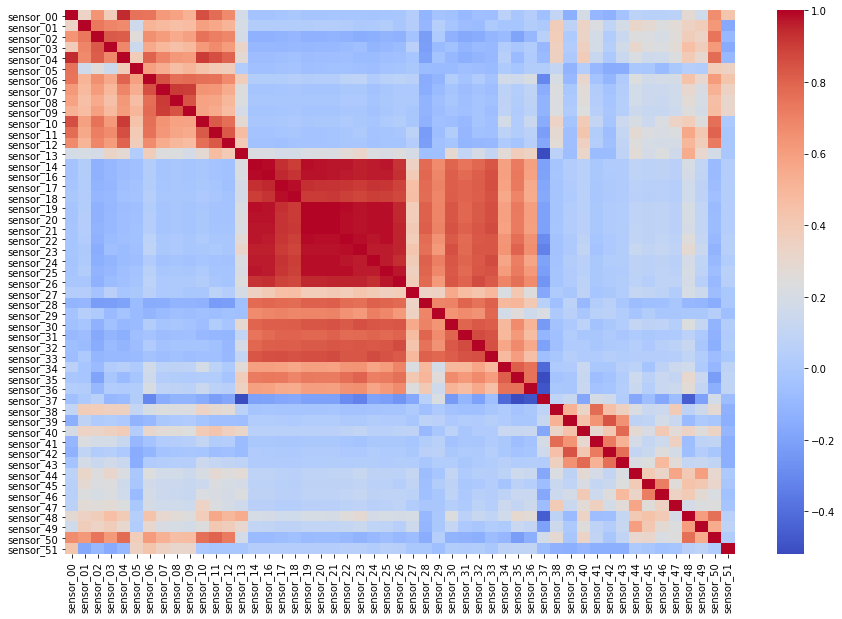

In [21]:
plt.figure(figsize=(15,10))
sns.heatmap(df.corr(),cmap='coolwarm')

In [22]:
df.drop(columns=col_na,inplace=True)

In [23]:
df[df['machine_status']=='BROKEN']

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,sensor_22,sensor_23,sensor_24,sensor_25,sensor_26,sensor_27,sensor_28,sensor_29,sensor_30,sensor_31,sensor_32,sensor_33,sensor_34,sensor_35,sensor_36,sensor_37,sensor_38,sensor_39,sensor_40,sensor_41,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,machine_status
17155,0.000000,53.342010,52.821180,43.402775,202.526031,49.79289,3.219039,16.890910,16.869210,15.082470,35.530850,3.625588,1.602259,0.237091,407.4979,451.3286,449.1867,2.387357,652.2382,390.5987,858.3630,461.2751,955.74270,614.6786,653.9383,753.0676,570.81680,1161.1310,783.6125,710.6481,960.9374,742.2943,566.6204,261.7709,399.129100,301.1411,114.20790,52.08333,35.41666,87.23958,39.583330,36.979160,50.78125,50.92593,51.215280,50.636570,46.006940,409.143500,121.527800,BROKEN
24510,1.093982,42.534720,47.699650,41.449650,206.038757,60.30106,12.304690,15.154800,14.185470,13.867190,28.304880,30.434710,21.437910,6.803444,420.0946,460.7847,457.7386,2.481055,664.2351,398.1912,879.1428,458.3324,944.30770,625.1230,650.4600,748.0622,502.59550,1063.0030,784.2626,671.2963,1016.6670,828.1685,578.9925,177.4708,411.165200,434.2556,73.31284,37.76041,32.81250,71.61458,28.645830,29.947916,42.70833,34.72222,31.539350,34.432870,33.275460,59.895830,44.560180,BROKEN
69318,2.258796,47.265630,52.734370,43.446178,200.115738,66.14643,13.592300,15.914350,15.147570,14.793110,43.998860,43.623220,22.736040,9.277993,420.3359,463.0843,462.6495,2.539193,665.5446,399.1660,880.9252,498.6224,997.63640,619.0558,719.8438,867.5176,551.63670,1154.4050,761.1199,655.5555,1024.4790,849.8132,608.9143,171.3203,350.311700,285.3491,75.20248,47.39583,29.16667,66.66666,32.291660,31.250000,39.06250,35.01157,37.905090,39.062500,45.428240,144.675900,49.768520,BROKEN
77790,2.321759,47.482640,51.475693,42.795135,612.152800,67.30158,14.062500,16.608800,15.943290,15.596060,27.092980,44.793620,32.745590,2.178048,420.7917,463.3876,464.5768,2.557975,665.4158,399.1982,885.1603,533.6134,982.50690,627.0386,746.0360,854.0722,478.34040,1095.9630,724.8124,698.6111,971.8749,882.1304,499.8158,171.7490,354.075700,250.9113,72.70645,381.77080,417.18750,427.34370,212.760400,176.822900,202.34370,65.68287,57.870370,127.893500,153.935200,155.381900,65.682870,BROKEN
128040,0.364005,40.190970,45.225690,40.190971,201.368622,0.00000,11.335360,15.270540,15.183740,15.118630,2.002474,1.960537,0.000000,0.000000,197.9393,206.4634,193.7957,0.444666,108.9490,125.4787,158.0601,128.2272,96.38937,103.7937,143.1029,156.3189,21.31752,258.0632,109.4662,297.2222,575.0000,436.2560,258.6194,343.9342,694.479126,367.8615,23.78439,28.38542,22.13542,36.71875,23.177082,24.739580,32.29166,28.06713,28.067129,29.513889,29.224537,29.224537,29.513889,BROKEN
141131,0.001968,45.138890,52.907990,45.355900,500.000000,1.40131,0.028935,0.036169,0.036169,0.007234,25.977650,23.970270,19.995600,11.076400,421.6618,464.8507,470.9483,2.632338,669.1102,399.5446,880.8264,536.3282,1091.49300,628.2361,759.8998,946.8455,509.98580,1042.8290,562.6080,668.9814,1037.5000,947.3692,517.4770,287.9145,575.356500,616.8983,30.04753,48.69791,31.51042,39.32291,35.416660,32.812500,36.19791,37.32639,35.300930,38.194440,43.402780,99.537030,44.849540,BROKEN
166440,2.318808,45.833332,52.994790,43.880210,420.503448,72.52040,14.185470,16.247110,15.697340,15.053530,36.717480,50.046190,30.742880,12.217860,420.8600,463.5181,455.2702,2.468381,665.9402,399.0930,880.8410,531.8727,1093.57900,626.4651,740.6738,981.4561,490.77280,1023.1660,551.2756,703.7037,971.8749,1013.3760,546.6656,363.0320,522.559400,812.8298,44.77601,50.00000,39.06250,102.86460,35.416660,36.458330,51.30208,52.10200,52.662040,67.129630,43.981480,230.324100,69.733800,BROKEN


In [24]:
df.dropna(inplace=True)

In [25]:
len(df)

208785

In [26]:
a=df.isnull().sum()/len(df)*100
a[a>0]

Series([], dtype: float64)

In [27]:
df.head()

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,sensor_22,sensor_23,sensor_24,sensor_25,sensor_26,sensor_27,sensor_28,sensor_29,sensor_30,sensor_31,sensor_32,sensor_33,sensor_34,sensor_35,sensor_36,sensor_37,sensor_38,sensor_39,sensor_40,sensor_41,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,machine_status
0,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,37.22740,47.52422,31.11716,1.681353,419.5747,461.8781,466.3284,2.565284,665.3993,398.9862,880.0001,498.8926,975.9409,627.6740,741.7151,848.0708,429.0377,785.1935,684.9443,594.4445,682.8125,680.4416,433.7037,171.9375,341.9039,195.0655,90.32386,40.36458,31.51042,70.57291,30.98958,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,NORMAL
1,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,37.22740,47.52422,31.11716,1.681353,419.5747,461.8781,466.3284,2.565284,665.3993,398.9862,880.0001,498.8926,975.9409,627.6740,741.7151,848.0708,429.0377,785.1935,684.9443,594.4445,682.8125,680.4416,433.7037,171.9375,341.9039,195.0655,90.32386,40.36458,31.51042,70.57291,30.98958,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,NORMAL
2,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,15.61777,15.01013,37.86777,48.17723,32.08894,1.708474,420.8480,462.7798,459.6364,2.500062,666.2234,399.9418,880.4237,501.3617,982.7342,631.1326,740.8031,849.8997,454.2390,778.5734,715.6266,661.5740,721.8750,694.7721,441.2635,169.9820,343.1955,200.9694,93.90508,41.40625,31.25000,69.53125,30.46875,31.770830,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,NORMAL
3,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,15.69734,15.08247,38.57977,48.65607,31.67221,1.579427,420.7494,462.8980,460.8858,2.509521,666.0114,399.1046,878.8917,499.0430,977.7520,625.4076,739.2722,847.7579,474.8731,779.5091,690.4011,686.1111,754.6875,683.3831,446.2493,166.4987,343.9586,193.1689,101.04060,41.92708,31.51042,72.13541,30.46875,31.510420,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,NORMAL
4,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,15.69734,15.08247,39.48939,49.06298,31.95202,1.683831,419.8926,461.4906,468.2206,2.604785,663.2111,400.5426,882.5874,498.5383,979.5755,627.1830,737.6033,846.9182,408.8159,785.2307,704.6937,631.4814,766.1458,702.4431,433.9081,164.7498,339.9630,193.8770,101.70380,42.70833,31.51042,76.82291,30.98958,31.510420,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,NORMAL


In [28]:
# a=df[df['machine_status']=='RECOVERING'].index
# a

In [29]:
# df.drop(a,inplace=True)

In [30]:
len(df)

208785

In [31]:
df.describe()

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,sensor_22,sensor_23,sensor_24,sensor_25,sensor_26,sensor_27,sensor_28,sensor_29,sensor_30,sensor_31,sensor_32,sensor_33,sensor_34,sensor_35,sensor_36,sensor_37,sensor_38,sensor_39,sensor_40,sensor_41,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49
count,208785.000000,208785.000000,208785.000000,208785.000000,208785.000000,208785.000000,208785.000000,208785.000000,208785.000000,208785.000000,208785.000000,208785.000000,208785.000000,208785.000000,208785.000000,208785.000000,208785.000000,208785.000000,208785.000000,208785.000000,208785.000000,208785.000000,208785.000000,208785.000000,208785.000000,208785.000000,208785.000000,208785.000000,208785.000000,208785.000000,208785.000000,208785.000000,208785.000000,208785.000000,208785.000000,208785.000000,208785.000000,208785.000000,208785.000000,208785.000000,208785.000000,208785.000000,208785.000000,208785.000000,208785.000000,208785.000000,208785.000000,208785.000000,208785.000000
mean,2.378394,48.062198,51.457813,44.095539,618.132019,74.099769,13.730393,16.056610,15.375228,14.989267,43.519461,43.996750,30.629231,7.444519,375.158305,414.671579,419.593799,2.295606,587.916665,359.319765,793.004287,457.942816,917.897388,553.085934,646.445031,783.557283,497.708131,839.629996,573.985653,610.356564,856.365187,798.792240,483.787818,236.002418,425.178535,594.811652,59.993082,50.533984,36.761709,70.554448,35.680428,35.492314,44.264713,43.231334,43.598518,48.660533,44.924554,156.844507,58.272915
std,0.394643,2.456816,2.428235,1.760128,76.991391,13.474402,1.488044,1.395684,1.359399,1.348996,8.194270,9.473059,7.866350,6.887889,115.185543,128.226854,131.451612,0.780095,202.825665,103.763525,230.751388,157.257613,296.590783,184.873630,224.885053,250.867943,164.174374,314.568142,228.669441,199.296018,285.821051,261.366163,153.040068,89.480154,143.304677,292.360332,37.709250,9.679299,12.251167,18.973630,7.052674,7.135405,8.407115,11.503806,12.621307,14.848569,10.323319,79.841255,18.574780
min,0.000000,0.000000,33.810760,33.289930,2.798032,0.000000,0.014468,0.000000,0.028935,0.007234,0.000000,0.000000,0.000000,0.000000,32.409550,0.000000,0.000000,0.000000,0.000000,0.000000,95.527660,0.000000,0.000000,0.000000,0.000000,43.154790,0.000000,4.319347,0.636574,0.000000,23.958330,0.240716,6.460602,54.882370,0.000000,2.260970,0.000000,24.739580,19.531250,23.958330,20.833330,22.656250,25.260416,26.620370,26.620370,27.488426,27.777780,27.199070,27.777779
25%,2.438831,46.657990,50.607635,43.055550,627.893500,70.189760,13.353590,15.914350,15.183740,15.053530,41.316110,39.924840,29.605040,1.692635,418.285900,459.665100,454.260300,2.448871,662.944200,398.103100,875.681700,479.726000,951.166000,600.718800,695.217800,795.365000,446.574400,776.031100,520.379300,625.925900,833.333300,751.164200,488.896800,172.385100,350.600200,266.751900,27.572960,45.833330,32.812500,58.854160,32.812500,33.072910,40.104164,37.615740,37.615740,40.798611,39.641200,90.277780,48.321760
50%,2.456539,48.220490,51.736110,44.314236,633.217590,75.481250,13.650170,16.167530,15.494790,15.082470,44.591760,45.823480,32.753350,3.501638,420.104700,462.845400,462.037800,2.533890,665.698500,399.377300,879.725300,531.812100,981.703100,625.779500,740.279100,855.928300,492.983700,946.979000,565.506000,667.129600,913.541600,877.972500,511.688300,227.578700,472.192800,759.908300,63.451810,49.739580,35.677080,66.927080,35.156250,35.156250,43.229160,40.798610,40.509260,45.138890,42.534721,143.807900,53.240740
75%,2.499826,49.522570,52.821180,45.355900,637.962952,80.505380,14.539930,16.427950,15.697340,15.118630,47.630420,49.865230,35.069630,13.031680,420.967300,464.262200,466.852900,2.587590,667.172400,400.099700,882.191400,534.262200,1090.744000,628.591400,750.156000,909.815400,535.490100,1025.870000,739.639700,696.7

In [32]:
# df['target']=0
# a=(df['machine_status']=='BROKEN') | (df['machine_status']=='RECOVERING')
df['target']=df['machine_status'].apply(lambda x:1 if x in ['RECOVERING','BROKEN'] else 0)

In [33]:
df['target'].value_counts()

0    205067
1      3718
Name: target, dtype: int64

In [34]:
df.head()

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,sensor_22,sensor_23,sensor_24,sensor_25,sensor_26,sensor_27,sensor_28,sensor_29,sensor_30,sensor_31,sensor_32,sensor_33,sensor_34,sensor_35,sensor_36,sensor_37,sensor_38,sensor_39,sensor_40,sensor_41,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,machine_status,target
0,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,37.22740,47.52422,31.11716,1.681353,419.5747,461.8781,466.3284,2.565284,665.3993,398.9862,880.0001,498.8926,975.9409,627.6740,741.7151,848.0708,429.0377,785.1935,684.9443,594.4445,682.8125,680.4416,433.7037,171.9375,341.9039,195.0655,90.32386,40.36458,31.51042,70.57291,30.98958,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,NORMAL,0
1,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,37.22740,47.52422,31.11716,1.681353,419.5747,461.8781,466.3284,2.565284,665.3993,398.9862,880.0001,498.8926,975.9409,627.6740,741.7151,848.0708,429.0377,785.1935,684.9443,594.4445,682.8125,680.4416,433.7037,171.9375,341.9039,195.0655,90.32386,40.36458,31.51042,70.57291,30.98958,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,NORMAL,0
2,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,15.61777,15.01013,37.86777,48.17723,32.08894,1.708474,420.8480,462.7798,459.6364,2.500062,666.2234,399.9418,880.4237,501.3617,982.7342,631.1326,740.8031,849.8997,454.2390,778.5734,715.6266,661.5740,721.8750,694.7721,441.2635,169.9820,343.1955,200.9694,93.90508,41.40625,31.25000,69.53125,30.46875,31.770830,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,NORMAL,0
3,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,15.69734,15.08247,38.57977,48.65607,31.67221,1.579427,420.7494,462.8980,460.8858,2.509521,666.0114,399.1046,878.8917,499.0430,977.7520,625.4076,739.2722,847.7579,474.8731,779.5091,690.4011,686.1111,754.6875,683.3831,446.2493,166.4987,343.9586,193.1689,101.04060,41.92708,31.51042,72.13541,30.46875,31.510420,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,NORMAL,0
4,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,15.69734,15.08247,39.48939,49.06298,31.95202,1.683831,419.8926,461.4906,468.2206,2.604785,663.2111,400.5426,882.5874,498.5383,979.5755,627.1830,737.6033,846.9182,408.8159,785.2307,704.6937,631.4814,766.1458,702.4431,433.9081,164.7498,339.9630,193.8770,101.70380,42.70833,31.51042,76.82291,30.98958,31.510420,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,NORMAL,0


In [35]:
df['machine_status'].value_counts()

NORMAL        205067
RECOVERING      3711
BROKEN             7
Name: machine_status, dtype: int64

In [36]:
df[df['machine_status']=='RECOVERING'].head()

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,sensor_22,sensor_23,sensor_24,sensor_25,sensor_26,sensor_27,sensor_28,sensor_29,sensor_30,sensor_31,sensor_32,sensor_33,sensor_34,sensor_35,sensor_36,sensor_37,sensor_38,sensor_39,sensor_40,sensor_41,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,machine_status,target
17156,0.000000,53.55902,52.77777,43.402775,204.725098,53.74214,3.045428,17.42621,15.740740,16.17477,40.310710,3.730241,1.612210,0.318798,404.9974,450.2004,454.0266,2.448104,651.1287,390.6628,857.0173,461.6187,951.3060,612.6481,652.3843,750.5814,550.9968,1118.163,773.6210,704.6296,1003.1250,714.9668,548.0704,270.0769,403.3277,299.2007,110.5263,53.64583,35.41666,84.63541,40.62500,36.979164,49.47916,50.347220,51.21528,49.18982,49.47917,431.71300,133.10190,RECOVERING,1
17157,0.000000,53.55902,52.77777,43.402775,201.137131,52.49996,7.537616,13.53443,9.324364,16.05179,38.930980,3.816472,1.631223,0.342867,409.9810,447.9742,449.0287,2.410462,650.5953,390.4939,863.1273,458.5190,948.8156,615.3629,646.3538,749.3739,553.7806,1147.219,783.5280,716.2037,1040.1040,740.6817,561.4838,265.9168,415.0607,305.2495,115.3448,55.20833,35.15625,81.25000,40.88541,36.979160,48.17708,49.768520,50.92593,48.03241,53.81944,451.38890,140.04630,RECOVERING,1
17158,0.000000,52.77777,52.69097,43.402770,204.030655,57.19875,7.609953,16.60880,16.203700,16.09520,33.433750,3.860711,1.622106,0.304665,412.2902,449.5466,453.7787,2.429593,652.1424,390.2556,857.9081,461.1630,950.7607,614.9879,649.2152,746.4882,541.1052,1131.809,787.4129,678.2407,976.5624,719.6953,558.5663,266.8813,415.8537,306.2030,105.0438,57.03125,35.15625,79.16666,41.40625,36.718750,46.87500,48.032410,50.34722,47.45370,58.15972,466.43520,144.96530,RECOVERING,1
17159,0.000000,52.60416,52.73437,43.446180,203.567688,50.96181,7.573785,16.70284,16.160300,16.08796,33.132260,4.496508,1.650150,0.606178,408.3951,450.6098,444.7706,2.361692,652.0457,390.4180,858.0203,460.7399,949.6810,614.2903,649.3373,748.6567,546.8779,1148.804,782.2913,682.4074,930.2083,723.4662,550.8478,263.7073,403.5153,303.2734,113.0340,57.55208,35.41666,75.26041,42.18750,36.718750,45.83333,47.453700,49.76852,46.58565,63.65741,474.82640,149.01620,RECOVERING,1
18076,0.305961,47.82986,50.17361,43.793400,123.747108,15.09307,6.438078,16.39178,16.464120,16.35561,2.628036,0.408536,0.000000,0.000000,407.4210,449.5779,444.4110,2.351429,649.4633,389.5570,866.0917,459.5412,949.3724,611.5058,648.6921,749.5519,548.2968,1140.955,784.8925,661.5740,930.2083,736.4288,563.5857,168.5924,403.7115,923.7798,113.3796,42.18750,35.15625,44.53125,36.19791,36.197910,42.70833,36.458332,36.45833,38.19444,38.19444,36.16898,36.16898,RECOVERING,1


In [37]:
df[df['target']==1].head()

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,sensor_22,sensor_23,sensor_24,sensor_25,sensor_26,sensor_27,sensor_28,sensor_29,sensor_30,sensor_31,sensor_32,sensor_33,sensor_34,sensor_35,sensor_36,sensor_37,sensor_38,sensor_39,sensor_40,sensor_41,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,machine_status,target
17155,0.0,53.34201,52.82118,43.402775,202.526031,49.79289,3.219039,16.89091,16.869210,15.08247,35.53085,3.625588,1.602259,0.237091,407.4979,451.3286,449.1867,2.387357,652.2382,390.5987,858.3630,461.2751,955.7427,614.6786,653.9383,753.0676,570.8168,1161.131,783.6125,710.6481,960.9374,742.2943,566.6204,261.7709,399.1291,301.1411,114.2079,52.08333,35.41666,87.23958,39.58333,36.979160,50.78125,50.92593,51.21528,50.63657,46.00694,409.1435,121.5278,BROKEN,1
17156,0.0,53.55902,52.77777,43.402775,204.725098,53.74214,3.045428,17.42621,15.740740,16.17477,40.31071,3.730241,1.612210,0.318798,404.9974,450.2004,454.0266,2.448104,651.1287,390.6628,857.0173,461.6187,951.3060,612.6481,652.3843,750.5814,550.9968,1118.163,773.6210,704.6296,1003.1250,714.9668,548.0704,270.0769,403.3277,299.2007,110.5263,53.64583,35.41666,84.63541,40.62500,36.979164,49.47916,50.34722,51.21528,49.18982,49.47917,431.7130,133.1019,RECOVERING,1
17157,0.0,53.55902,52.77777,43.402775,201.137131,52.49996,7.537616,13.53443,9.324364,16.05179,38.93098,3.816472,1.631223,0.342867,409.9810,447.9742,449.0287,2.410462,650.5953,390.4939,863.1273,458.5190,948.8156,615.3629,646.3538,749.3739,553.7806,1147.219,783.5280,716.2037,1040.1040,740.6817,561.4838,265.9168,415.0607,305.2495,115.3448,55.20833,35.15625,81.25000,40.88541,36.979160,48.17708,49.76852,50.92593,48.03241,53.81944,451.3889,140.0463,RECOVERING,1
17158,0.0,52.77777,52.69097,43.402770,204.030655,57.19875,7.609953,16.60880,16.203700,16.09520,33.43375,3.860711,1.622106,0.304665,412.2902,449.5466,453.7787,2.429593,652.1424,390.2556,857.9081,461.1630,950.7607,614.9879,649.2152,746.4882,541.1052,1131.809,787.4129,678.2407,976.5624,719.6953,558.5663,266.8813,415.8537,306.2030,105.0438,57.03125,35.15625,79.16666,41.40625,36.718750,46.87500,48.03241,50.34722,47.45370,58.15972,466.4352,144.9653,RECOVERING,1
17159,0.0,52.60416,52.73437,43.446180,203.567688,50.96181,7.573785,16.70284,16.160300,16.08796,33.13226,4.496508,1.650150,0.606178,408.3951,450.6098,444.7706,2.361692,652.0457,390.4180,858.0203,460.7399,949.6810,614.2903,649.3373,748.6567,546.8779,1148.804,782.2913,682.4074,930.2083,723.4662,550.8478,263.7073,403.5153,303.2734,113.0340,57.55208,35.41666,75.26041,42.18750,36.718750,45.83333,47.45370,49.76852,46.58565,63.65741,474.8264,149.0162,RECOVERING,1


In [38]:
df.drop(columns='machine_status',inplace=True)

In [39]:
df.head()

,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12,sensor_13,sensor_14,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21,sensor_22,sensor_23,sensor_24,sensor_25,sensor_26,sensor_27,sensor_28,sensor_29,sensor_30,sensor_31,sensor_32,sensor_33,sensor_34,sensor_35,sensor_36,sensor_37,sensor_38,sensor_39,sensor_40,sensor_41,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,target
0,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,37.22740,47.52422,31.11716,1.681353,419.5747,461.8781,466.3284,2.565284,665.3993,398.9862,880.0001,498.8926,975.9409,627.6740,741.7151,848.0708,429.0377,785.1935,684.9443,594.4445,682.8125,680.4416,433.7037,171.9375,341.9039,195.0655,90.32386,40.36458,31.51042,70.57291,30.98958,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,0
1,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,15.05353,37.22740,47.52422,31.11716,1.681353,419.5747,461.8781,466.3284,2.565284,665.3993,398.9862,880.0001,498.8926,975.9409,627.6740,741.7151,848.0708,429.0377,785.1935,684.9443,594.4445,682.8125,680.4416,433.7037,171.9375,341.9039,195.0655,90.32386,40.36458,31.51042,70.57291,30.98958,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,0
2,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,15.61777,15.01013,37.86777,48.17723,32.08894,1.708474,420.8480,462.7798,459.6364,2.500062,666.2234,399.9418,880.4237,501.3617,982.7342,631.1326,740.8031,849.8997,454.2390,778.5734,715.6266,661.5740,721.8750,694.7721,441.2635,169.9820,343.1955,200.9694,93.90508,41.40625,31.25000,69.53125,30.46875,31.770830,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,0
3,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,15.69734,15.08247,38.57977,48.65607,31.67221,1.579427,420.7494,462.8980,460.8858,2.509521,666.0114,399.1046,878.8917,499.0430,977.7520,625.4076,739.2722,847.7579,474.8731,779.5091,690.4011,686.1111,754.6875,683.3831,446.2493,166.4987,343.9586,193.1689,101.04060,41.92708,31.51042,72.13541,30.46875,31.510420,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,0
4,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,15.69734,15.08247,39.48939,49.06298,31.95202,1.683831,419.8926,461.4906,468.2206,2.604785,663.2111,400.5426,882.5874,498.5383,979.5755,627.1830,737.6033,846.9182,408.8159,785.2307,704.6937,631.4814,766.1458,702.4431,433.9081,164.7498,339.9630,193.8770,101.70380,42.70833,31.51042,76.82291,30.98958,31.510420,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,0


In [40]:
X=df.drop('target',axis=1)
y=df['target']
n_fold=5
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=42)

In [41]:
def train_model(X, y, params, folds, model_type='lgb', plot_feature_importance=False, averaging='usual', model=None):
    oof = np.zeros(len(X))
    scores = []
    feature_importance = pd.DataFrame()
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y)):
        print('Fold', fold_n, 'started at', time.ctime())
        X_train, X_valid = X.loc[train_index], X.loc[valid_index]
        y_train, y_valid = y[train_index], y[valid_index]
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_valid = scaler.transform(X_valid)
        
        if model_type == 'lgb':
            train_data = lgb.Dataset(X_train, label=y_train)
            valid_data = lgb.Dataset(X_valid, label=y_valid)
            
            model = lgb.train(params,
                    train_data,
                    num_boost_round=1000,
                    valid_sets = [train_data, valid_data],
                    verbose_eval=500,
                    early_stopping_rounds = 200)
            
            y_pred_valid = model.predict(X_valid)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X_train.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X_train.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=500, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X_train.columns), ntree_limit=model.best_ntree_limit)
        
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            y_pred_valid = model.predict_proba(X_valid)[:, 1]
            score = roc_auc_score(y_valid, y_pred_valid)
            # print(f'Fold {fold_n}. AUC: {score:.4f}.')
            # print('')
            
            
        if model_type == 'glm':
            model = sm.GLM(y_train, X_train, family=sm.families.Binomial())
            model_results = model.fit()
            model_results.predict(X_test)
            y_pred_valid = model_results.predict(X_valid).reshape(-1,)
            score = roc_auc_score(y_valid, y_pred_valid)
            
            
        if model_type == 'cat':
            model = CatBoostClassifier(iterations=20000, learning_rate=0.05, loss_function='Logloss',  eval_metric='AUC', **params)
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict_proba(X_valid)[:, 1]
            
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(roc_auc_score(y_valid, y_pred_valid))
        
        if model_type == 'lgb':
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = X.columns
            fold_importance["importance"] = model.feature_importance()
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)


    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    if model_type == 'lgb':
        feature_importance["importance"] /= n_fold
        if plot_feature_importance:
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
        
            return oof,  feature_importance
        return oof,  scores
    
    else:
        return oof,  scores

In [42]:
xgb=XGBRegressor()

In [43]:
# y[y==1]

In [44]:
X_sm,y_sm=smote.fit_sample(X,y.ravel())

In [45]:
len(y_sm[y_sm==1])

205067

In [46]:
len(y_sm)

410134

In [47]:
params = {'num_leaves': 8,
         'min_data_in_leaf': 42,
         'objective': 'binary',
         'max_depth': 5,
         'learning_rate': 0.01,
         'boosting': 'gbdt',
         'bagging_freq': 5,
         'feature_fraction': 0.8201,
         'bagging_seed': 11,
         'reg_alpha': 1,
         'reg_lambda': 4,
         'random_state': 42,
         'metric': 'auc',
         'verbosity': -1,
         'subsample': 0.81,
         'num_threads': 4}

Fold 0 started at Mon Sep 21 15:03:25 2020
Training until validation scores don't improve for 200 rounds
[500]	training's auc: 0.999998	valid_1's auc: 0.999997
[1000]	training's auc: 1	valid_1's auc: 1
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 1	valid_1's auc: 1
Fold 1 started at Mon Sep 21 15:04:14 2020
Training until validation scores don't improve for 200 rounds
[500]	training's auc: 0.999998	valid_1's auc: 0.999998
[1000]	training's auc: 1	valid_1's auc: 1
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 1	valid_1's auc: 1
Fold 2 started at Mon Sep 21 15:05:01 2020
Training until validation scores don't improve for 200 rounds
[500]	training's auc: 0.999997	valid_1's auc: 0.999998
[1000]	training's auc: 1	valid_1's auc: 1
Did not meet early stopping. Best iteration is:
[1000]	training's auc: 1	valid_1's auc: 1
Fold 3 started at Mon Sep 21 15:05:46 2020
Training until validation scores don't improve for 200 rounds
[500]	training's au

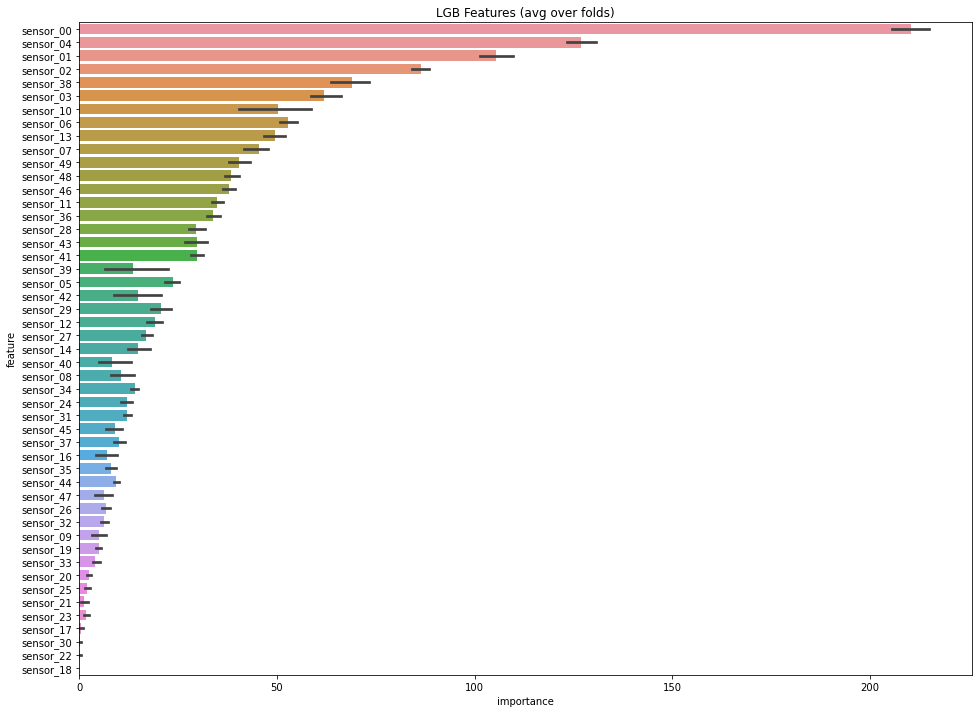

In [48]:
oof_lgb, scores = train_model(X_sm, y_sm, params=params, folds=folds, model_type='lgb', plot_feature_importance=True)

In [50]:
# oof_lr, scores = train_model(X, y, params=None, folds=folds, model_type='sklearn')